### Подключение библиотек

In [ ]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download # Отображение китайских иероглифов на графиках

import pandas as pd
import jieba
import re
from tqdm import tqdm
from gensim.models import Word2Vec
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager
import seaborn as sns
from sklearn.manifold import TSNE

# 改style要在改font之前
# plt.style.use('seaborn')  

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2022-10-27 22:29:22--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 209.85.147.138, 209.85.147.113, 209.85.147.100, ...
Connecting to drive.google.com (drive.google.com)|209.85.147.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e6o422gpfsdg17idnvqtb3442t363elr/1666909725000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=2bdd6666-6c68-4d5a-9658-68b642ca243f [following]
--2022-10-27 22:29:26--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e6o422gpfsdg17idnvqtb3442t363elr/1666909725000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=2bdd6666-6c68-4d5a-9658-68b642ca243f
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 173.194.195.132, 2607:f8b0:4001:c11::84
Connecting to doc-0

### Обработка датасета (сегментация, удаление стоп-слов и символов)

In [ ]:
df = pd.read_csv('/content/guba_dataset.csv')
df = df[['text']]

In [ ]:
df['text'].head()

0             过年之前还有回本的希望吗？？？？
1    今日竞价选出跨境通、大中矿业，二进三都挂单买入。开
2        老道早盘展望：外围情绪好，大A春天来了嘛？
3                     就看今天怎么说了
4                        66666
Name: text, dtype: object

In [ ]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\-]+"

stopwords_ch = ['the', 'of', 'is', 'and', 'to', 'in', 'that', 'we', 'for', 'an', 'are', 'by', 'be', 'as', 'on', 'with',
                'can', 'if', 'from', 'which', 'you', 'it', 'this', 'then', 'at', 'have', 'all', 'not', 'one', 'has',
                'or', 'that', '的', '了', '和', '是', '就', '都', '而', '及', '與', '著', '或', '一個', '沒有', '我們',
                '你們', '妳們', '他們', '她們', '是否', '︿', '！', '＃', '＄', '％', '＆', '（', '）', '＊', '＋', '，',
                '０', '１', '２', '３', '４', '５', '６', '７', '８', '９', '：', '；', '＜', '＞', '？', '＠', '［', '］',
                '｛', '｜', '｝', '～', '￥', '。', '「', '」', '、', '‧', '《', '》', '〈', '〉', '【', '】', '…', ' ']

def segmentation(post):
  post = re.sub(patterns, ' ', str(post))
  tokens = []

  for token in jieba.lcut(post):

    if token and token not in stopwords_ch:
      token = token.strip()
      if token != '':
        tokens.append(token)

  if len(tokens) > 0:
    return tokens

  return None

In [ ]:
tqdm.pandas(desc='Segmentation progress')
data = df.progress_apply(segmentation, axis=1)

Progress segmentation:   0%|          | 0/1366686 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.101 seconds.
DEBUG:jieba:Loading model cost 1.101 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
Progress segmentation: 100%|██████████| 1366686/1366686 [18:09<00:00, 1254.38it/s]


In [ ]:
data = data.dropna()

In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data

0                                  [过年, 之前, 还有, 回本, 希望, 吗]
1          [今日, 竞价, 选出, 跨境, 通, 大, 中, 矿业, 二进, 三, 挂单, 买入, 开]
2                     [老道, 早盘, 展望, 外围, 情绪, 好, 大, 春天, 来, 嘛]
3                                           [看, 今天, 怎么, 说]
4                                    [跨境, 通, 月, 日, 快速, 上涨]
                                ...                       
1362255                                    [茅台, 可以, 进, 目标]
1362256      [其实, 抵治茅, 抬, 办法, 很, 简单, 鸡精, 用, 我们, 钱, 堆高, 茅价]
1362257                       [中信, 别, 出来, 说, 那个, 好, 那个, 跌]
1362258          [茅台, 年底, 也, 这样, 持续, 走低, 预计, 也, 如此, 何不, 出]
1362259                       [跌, 到, 轨道, 下轨, 买进, 较, 好, 机会]
Length: 1362260, dtype: object

### Построение модели

In [ ]:
w2v_model = Word2Vec(min_count=5, window=3, size=800, sg=1, workers=16)
w2v_model.build_vocab(data)

In [ ]:
w2v_model.train(data, total_examples=w2v_model.corpus_count, epochs=30)

(268955782, 294948150)

In [ ]:
w2v_model.init_sims(replace=True)

In [ ]:
w2v_model.wv.most_similar(positive=['大户'], topn=20) # Наиболее подходящие слова

[('中户', 0.48527663946151733),
 ('大庄', 0.37235307693481445),
 ('主卖', 0.3698011338710785),
 ('低出', 0.3688352704048157),
 ('小散接', 0.3675019443035126),
 ('小户', 0.36608555912971497),
 ('那路', 0.36487895250320435),
 ('蠢驴', 0.36162686347961426),
 ('剩小散', 0.35944363474845886),
 ('内外勾结', 0.35440224409103394),
 ('互割', 0.3541947603225708),
 ('大户人家', 0.3530515432357788),
 ('压出来', 0.3529290556907654),
 ('仓皇出逃', 0.34932103753089905),
 ('互杀', 0.34702062606811523),
 ('拼了命', 0.3469400703907013),
 ('诱套', 0.34659209847450256),
 ('地压', 0.34638020396232605),
 ('自卖', 0.3461809754371643),
 ('成泉', 0.3454458713531494)]

In [ ]:
def tsne_scatterplot(model, word, list_names): # Построение векторов слов в двухмерном пространстве
  vectors_words = [model.wv.word_vec(word)]
  word_labels = [word]
  color_list = ['red']
  close_words = model.wv.most_similar(word, topn=25)
  for wrd_score in close_words:
    wrd_vector = model.wv.word_vec(wrd_score[0])
    vectors_words.append(wrd_vector)
    word_labels.append(wrd_score[0])
    color_list.append('blue')


  for wrd in list_names:
    wrd_vector = model.wv.word_vec(wrd)
    vectors_words.append(wrd_vector)
    word_labels.append(wrd)
    color_list.append('green')


  Y = (TSNE(n_components=2, random_state=0, perplexity=15, init='pca').fit_transform(vectors_words))


  df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                    'y': [y for y in Y[:, 1]],
                    'words': word_labels,
                    'color': color_list})

  fig, _ = plt.subplots()

  fig.set_size_inches(9, 9)


  p1 = sns.regplot(data=df, x='x', y='y', fit_reg=False, marker='o', scatter_kws={'s': 40, 'facecolors': df['color']})


  for line in range(0, df.shape[0]):
    p1.text(df['x'][line], df['y'][line], ' ' + df['words'][line].title(), horizontalalignment='left',
            verticalalignment='bottom', size='medium', color=df['color'][line], weight='normal').set_size(15)

  plt.xlim(Y[:, 0].min()-150, Y[:, 0].max()+150)
  plt.ylim(Y[:, 1].min()-150, Y[:, 1].max()+150)
  plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


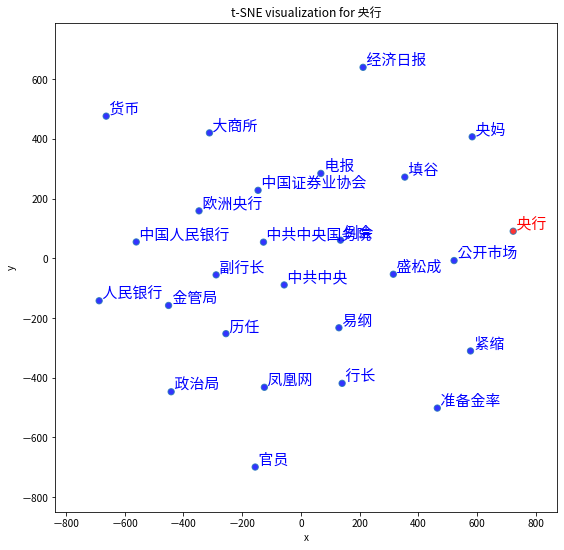

In [ ]:
tsne_scatterplot(w2v_model, '央行', []) # Построение графика